In [23]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [24]:
def get_trial_data(df, trial_name):
    # Find the start index of the trial
    start_index = df[df['USER'].str.contains(trial_name, case=False, na=False)].index[0]
    
    trial_number = trial_name.split(":")[0]
    end = f"{trial_number}: END"

    # Find the end index of the trial (next 'FIXATION_LOG' or 'STOP')
    next_fixation_mask = df['USER'].str.contains(re.escape(end), case=False, na=False)
    end_index = df[next_fixation_mask].index[df[next_fixation_mask].index > start_index].min()
    
    # If no next fixation or stop is found, take until the end of the DataFrame
    if pd.isna(end_index):
        end_index = df.shape[0]
    
    # Extract the trial data
    trial_data = df.loc[start_index:end_index].copy()

    if not trial_data.empty:
        trial_data['TIME'] = pd.to_numeric(trial_data['TIME'], errors='coerce')

        trial_data['TIME'] = trial_data['TIME'] - trial_data['TIME'].iloc[0]

    
    return trial_data

def dispersion(x, y):
    return (np.max(x)-np.min(x)) + (np.max(y)-np.min(y))

def i_dt(x, y, disp_t, dur_t_ms=25, smpl_freq=150):

    # compute number of samples in a time window
    dur_t_s = dur_t_ms/1000 # convert duration threshold to seconds
    dur_t = int(dur_t_s*smpl_freq)

    # initialize index
    i = 0
    fixations = {"fix_start_idx":[], "fix_end_idx":[]}

    # find the start and end of a fixation using the dispersion threshold and the time window
    while i + dur_t <= len(x):
        window_x = x.iloc[i:i+dur_t]
        window_y = y.iloc[i:i+dur_t]
        disp = dispersion(window_x,window_y)

        if disp > disp_t:
            i += 1
            continue

        j = 1
        while (i + dur_t + j <= len(x)) and (dispersion(x.iloc[i:i+dur_t+j],y.iloc[i:i+dur_t+j]) <= disp_t):
            j += 1

        j -= 1

        fixations["fix_start_idx"].append(i)
        fixations["fix_end_idx"].append(i+dur_t+j-1)

        i = i + dur_t + j

    return fixations

In [25]:
def label_fixation(row):
    try:
        val = float(row['BPOGX_start'])
    except (ValueError, TypeError):
        return 'unknown'
    if 0.4 <= val <= 0.6:
        return 'no image'
    elif val > 0.6:
        return 'right image'
    elif val < 0.4:
        return 'left image'
    else:
        return 'unknown'


In [26]:
def firstFixationPoints(subject_number,df_subject,condition_trials, dominant_eye):
    fixation_points = []
    count = 0
    for index, row in condition_trials.iterrows():   
        trial_name = row['USER']
        trial_data = get_trial_data(df_subject, trial_name)
        count = count + 1
        results_trial = i_dt(trial_data["BPOGX"], trial_data["BPOGY"], disp_t=0.1)
        results_trial_df = pd.DataFrame(results_trial)
        results_trial_df['subject'] = subject_number
        results_trial_df['dominant_eye'] = dominant_eye
        if results_trial_df.empty:
            continue 

        results_trial_df["fix_start"] = trial_data["TIME"].iloc[results_trial_df["fix_start_idx"]].values
        results_trial_df["fix_end"] = trial_data["TIME"].iloc[results_trial_df["fix_end_idx"]].values
        results_trial_df["fix_dur"] = results_trial_df["fix_end"] - results_trial_df["fix_start"]

        results_trial_df["BPOGX_start"] = trial_data["BPOGX"].iloc[results_trial_df["fix_start_idx"]].values
        results_trial_df["BPOGX_end"] = trial_data["BPOGX"].iloc[results_trial_df["fix_end_idx"]].values
        results_trial_df["BPOGY_start"] = trial_data["BPOGY"].iloc[results_trial_df["fix_start_idx"]].values
        results_trial_df["BPOGY_end"] = trial_data["BPOGY"].iloc[results_trial_df["fix_end_idx"]].values
        results_trial_df["label"] = results_trial_df.apply(label_fixation, axis=1)

            # filter the trial name, so that only the text after the : exits
            #trial_name_condition = trial_name.split(':')[-1].strip() 


        match = re.search(r'TRIAL \d+: ([^,]+), LEFT IMAGE: ([^,]+), RIGHT IMAGE: ([^,]+)', trial_name)

        if match:
            trial_name_condition = match.group(1).strip()
            left_image = match.group(2).strip()
            right_image = match.group(3).strip()

        #print("Trial Name:", trial_name_condition)
        #print("Left Image:", left_image)
        #print("Right Image:", right_image)
            #trial_name_condition = trial_name.split(":")[1].split(",")[0].strip()

            # then split the trial name by _
        trial_name_parts = trial_name_condition.split('_')

        form_level = ['ASYMMETRICAL','SYMMETRICAL']
        size_level = ['BIG','SMALL']
        background_level = ['CONTRARY','DOMINANT']

        if(trial_name_parts[0] == 'SIZE'):
            trial_cond = size_level
        elif(trial_name_parts[0] == 'FORM'):
            trial_cond = form_level
        elif(trial_name_parts[0] == "BACKGROUND"):
            trial_cond = background_level

        if(trial_name_parts[0] != 'BASELINE'):
            # if trial_name_parts[1]  is BIG then add label BIG to column 'level' if it is SMALL then add label SMALL
            if trial_name_parts[1].upper() == trial_cond[0]:
                results_trial_df['level'] = trial_cond[0]
            elif trial_name_parts[1].upper() == trial_cond[1]:
                results_trial_df['level'] = trial_cond[1]
            else:
                results_trial_df['level'] = 'UNKNOWN'
            # if trial_name_parts[2]  is L add label L to column 'image' , if it is R then add R
        if trial_name_parts[2].upper() == 'L':
            results_trial_df['image'] = 'L'
        elif trial_name_parts[2].upper() == 'R':
            results_trial_df['image'] = 'R'
        else:
            results_trial_df['image'] = 'UNKNOWN'
            # if left image contains INDOOR, then assign INDOOR label to column 'ImageCategoryLeft', if left image contains NATURE, then assign NATURE label to column 'ImageCategoryLeft',
            # if left image contains URBAN, then assign URBAN label to column 'ImageCategoryLeft',same for the right image
        if 'INDOOR' in left_image.upper():
            results_trial_df['ImageCategoryLeft'] = 'INDOOR'
        elif 'NATURE' in left_image.upper():
            results_trial_df['ImageCategoryLeft'] = 'NATURE'
        elif 'URBAN' in left_image.upper():
            results_trial_df['ImageCategoryLeft'] = 'URBAN'
        else:
            results_trial_df['ImageCategoryLeft'] = 'UNKNOWN'

        if 'INDOOR' in right_image.upper():
            results_trial_df['ImageCategoryRight'] = 'INDOOR'
        elif 'NATURE' in right_image.upper():
            results_trial_df['ImageCategoryRight'] = 'NATURE'
        elif 'URBAN' in right_image.upper():
            results_trial_df['ImageCategoryRight'] = 'URBAN'
        else:
            results_trial_df['ImageCategoryRight'] = 'UNKNOWN'

        valid_fixations = results_trial_df[results_trial_df['label'] != 'no image']
        if valid_fixations.empty:
            continue  # no valid fixations

        first_valid = valid_fixations.iloc[0]
        if trial_name_parts[0] == 'BASELINE':
            fixation_points.append({
            'trial': trial_name,
            'condition': trial_name_parts[0],
            'image' : first_valid['image'],
            'left_cat': first_valid['ImageCategoryLeft'],
            'right_cat': first_valid['ImageCategoryRight'],
            'label': first_valid['label'],
            'subject' : first_valid['subject']
            })
        else:
            fixation_points.append({
                'trial': trial_name,
                'condition': trial_name_parts[0],
                'level' : first_valid['level'],
                'image' : first_valid['image'],
                'left_cat': first_valid['ImageCategoryLeft'],
                'right_cat': first_valid['ImageCategoryRight'],
                'label': first_valid['label'],
                'subject' : first_valid['subject'],
                'dominant_eye': first_valid['dominant_eye']
            })
        #if fixation_points:
        


            #plt.figure(figsize=(10, 6))
            #plt.plot(trial_data['TIME'], trial_data['BPOGX'], label='BPOGX', color='blue', alpha=0.5)
            
            # use results_trial_df to plot the fixation start and end times
            #for idx, row in results_trial_df.iterrows():
             #   plt.axvline(x=row['fix_start'], color='green', linestyle='--', label='Fixation Start' if idx == 0 else "")
              #  plt.axvline(x=row['fix_end'], color='red', linestyle='--', label='Fixation End' if idx == 0 else "")

            #plt.title(f'Fixation Start and End Times for {trial_name}')
            #plt.xlabel('Time (s)')
            #plt.ylabel('BPOGX')
            #plt.xlim(trial_data['TIME'].min(), trial_data['TIME'].max())
            #plt.ylim(0, 1)
            #plt.gca().invert_yaxis()
            #plt.legend()
            #plt.grid(True)
            #plt.tight_layout()
            #plt.show()
    return fixation_points


def plotDistribution(fixation_points):

    level_one = []
    level_two = []
    level_baseline = []

    form_level = ['ASYMMETRICAL','SYMMETRICAL']
    size_level = ['BIG','SMALL']
    background_level = ['CONTRARY','DOMINANT']

    size = False
    form = False
    background = False

    for item in fixation_points:
        if(item['condition'] == 'SIZE'):
            trial_cond = size_level
            size = True
        elif(item['condition'] == 'FORM'):
            trial_cond = form_level
            form = True
        elif(item['condition'] == "BACKGROUND"):
            trial_cond = background_level
            background = True
        if item['condition'] != 'BASELINE':
            if item['level'] == trial_cond[0]:
                level_one.append(item)
            elif item['level'] == trial_cond[1]:
                level_two.append(item)
            else:
                print('Not the right level!!')
        else:
            level_baseline.append(item)

    count_R_right_1 = 0
    count_R_left_1 = 0
    count_L_right_1 = 0
    count_L_left_1 = 0

    for item in level_one:
        if item['condition'] != 'BASELINE':
            if item['image'] == 'R':
                if item['label'] == 'right image':
                    count_R_right_1 = count_R_right_1 + 1
                elif item['label'] == 'left image':
                    count_R_left_1 = count_R_left_1 + 1
                else: 
                    print('No valid first fixation.')
            elif item['image'] == 'L':
                if item['label'] == 'right image':
                    count_L_right_1 = count_L_right_1 + 1
                elif item['label'] == 'left image':
                    count_L_left_1 = count_L_left_1 + 1
                else: 
                    print('No valid first fixation.')

    count_R_right_2 = 0
    count_R_left_2 = 0
    count_L_right_2 = 0
    count_L_left_2 = 0

    for item in level_two:
        if item['condition'] != 'BASELINE':
            if item['image'] == 'R':
                if item['label'] == 'right image':
                    count_R_right_2 = count_R_right_2 + 1
                elif item['label'] == 'left image':
                    count_R_left_2 = count_R_left_2 + 1
                else: 
                    print('No valid first fixation.')
            elif item['image'] == 'L':
                if item['label'] == 'right image':
                    count_L_right_2 = count_L_right_2 + 1
                elif item['label'] == 'left image':
                    count_L_left_2 = count_L_left_2 + 1
                else: 
                    print('No valid first fixation.')


    count_right_baseline = 0
    count_left_baseline = 0
    baseline = False
    for item in level_baseline:
        if item['condition'] == 'BASELINE':
            baseline = True
            if item['label'] == 'right image':
                count_right_baseline = count_right_baseline + 1
            elif item['label'] == 'left image':
                count_left_baseline = count_left_baseline + 1
            else: 
                print('No valid first fixation.')

    barWidth = 0.25
    if baseline == False:

        

        fig,ax = plt.subplots(figsize=(12, 8))
        plt.grid(True)
       
        totalR = count_R_right_1 + count_R_left_1
        totalL = count_L_right_1 + count_L_left_1

        L = [count_L_left_1/totalL*100, count_L_right_1/totalL*100]
        R = [count_R_left_1/totalR*100, count_R_right_1/totalR*100]
        if size == True: 
            print('Condition SIZE')
        if form == True:
            print('Condition FORM')
        if background == True:
            print('Condition BACKGROUND')
        print("L: ", L)
        print("R: ", R)

        ax.barh(1, L[0], left=0, color='red', edgecolor='black', label='First Fixation left Image')
        ax.barh(1, L[1], left=L[0], color='blue', edgecolor='black', label='First Fixation right Image')

        ax.barh(0, R[0], left=0, color='orange', edgecolor='black', label='First Fixation left Image')
        ax.barh(0, R[1], left=R[0], color='green', edgecolor='black', label='First Fixation right Image')

        tickRight = trial_cond[0] + 'ConditionRight'
        tickLeft = trial_cond[0] + 'ConditionLeft'

        ax.set_yticks([0, 1])
        ax.set_yticklabels([tickRight, tickLeft])

        if size == True: 
            plt.title('Condition SIZE')
        if form == True:
            plt.title('Condition FORM')
        if background == True:
            plt.title('Condition BACKGROUND')


        plt.xlim(0,100)
        plt.legend()    


        fig, ax = plt.subplots(figsize=(12,8))
        plt.grid(True)
        if size == True: 
            print('Condition SIZE')
        if form == True:
            print('Condition FORM')
        if background == True:
            print('Condition BACKGROUND')
            

        totalR2 = count_R_right_2 + count_R_left_2
        totalL2 = count_L_right_2 + count_L_left_2
        
        L2 = [count_L_left_2/totalL2 * 100, count_L_right_2/totalL2 * 100]
        print("L2: ", L2)
        
        R2 = [count_R_left_2/totalR2 * 100, count_R_right_2/totalR2 * 100]
        print("R2: ", R2)


        ax.barh(1, L2[0], left=0, color='red', edgecolor='black', label='First Fixation left Image')
        ax.barh(1, L2[1], left=L2[0], color='blue', edgecolor='black', label='First Fixation right Image')

        ax.barh(0, R2[0], left=0, color='orange', edgecolor='black', label='First Fixation left Image')
        ax.barh(0, R2[1], left=R2[0], color='green', edgecolor='black', label='First Fixation right Image')

        tickLeft = trial_cond[1] + 'ConditionLeft'
        tickRight = trial_cond[1] + 'ConditionRight'


        if size == True: 
            plt.title('Condition SIZE')
        if form == True:
            plt.title('Condition FORM')
        if background == True:
            plt.title('Condition BACKGROUND')

        

        ax.set_yticks([0, 1])
        ax.set_yticklabels([tickRight, tickLeft])

        plt.xlim(0,100)


        plt.legend()
        plt.show() 

        return level_one, level_two

    else: 
        baseline = False
        counts = [count_left_baseline, count_right_baseline]
        images = ['First Fixation Left', 'First Fixation Right']

        colors = ['red', 'blue']

        total = sum(counts)
        percentages = [(c / total) * 100 if total != 0 else 0 for c in counts]
        print(percentages)

         # Create horizontal bar chart

        fig, ax = plt.subplots(figsize=(10, 2))
        left = 0
        for perc, color, label in zip(percentages, colors, images):
            ax.barh(0, perc, left=left, color=color, edgecolor='black', label=f'{label}')
            left += perc

        ax.set_xlim(0, 100)
        ax.set_yticks([])
        ax.set_title('Condition BASELINE')
        ax.legend()
        return level_baseline

        plt.show() 



    


In [27]:
def addColumns(data_path, subject_number, dominant_eye):
    df = pd.read_csv(data_path, sep='\t')
    df['subject'] = subject_number
    df['dominant_eye'] = dominant_eye
    return df

def preprocessData(df):
    df = df[df['FPOGV']==1]
    return df

def createSubjectFilePool():
    d = {'data_path': [ 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject01/subject-1.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject02/subject-2.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject03/subject-3.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject04/subject-4.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject05/subject-5.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject06/subject-6.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject07/subject-7.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject08/subject-8.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject09/subject-9.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject10/subject-10.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject11/subject-11.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject12/subject-12.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject13/subject-13.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject14/subject-14.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject15/subject-15.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject16/subject-16.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject17/subject-17.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject18/subject-18.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject19/subject-19.tsv', 'C:/Users/madle/Documents/UniSS25/subject_daten_2/subject20/subject-20.tsv'], 'subject_number': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'dominant_eye': ['left', 'right', 'left', 'right', 'left', 'right', 'right', 'right', 'right', 'right', 'left', 'left', 'left', 'right','right', 'left', 'left', 'right', 'right', 'right']}
    df = pd.DataFrame(data=d)
    return df

def create_entire_dataframe():
    df_files = createSubjectFilePool()
    all_data = []
    for index, row in df_files.iterrows():
        df_subject = addColumns(row['data_path'], row['subject_number'], row['dominant_eye'])
        df_subject = preprocessData(df_subject)
        all_data.append(df_subject)
    df_all = pd.DataFrame({'subject_data': all_data})
    return df_all


df_files = createSubjectFilePool()
df_all = create_entire_dataframe()


def plotCondition(trial_condition):
    all_fix_points = []
    for index, row in df_all.iterrows():
        df_subject = row['subject_data']
        subject_number = df_subject['subject'].iloc[0]
        dominant_eye = df_subject['dominant_eye'].iloc[0]
        trials = df_subject[df_subject['USER'].str.contains(trial_condition, na=False)]
        fix_points = firstFixationPoints(subject_number, df_subject, trials, dominant_eye)
        all_fix_points.extend(fix_points)
    return plotDistribution(all_fix_points)

baseline_fixpoints = plotCondition('BASELINE')
size_big_fixpoints, size_small_fixpoints = plotCondition('SIZE')
form_asym_fixpoints, form_sym_fixpoints = plotCondition('FORM')
background_con_fixpoints, background_dom_fixpoints = plotCondition('BACKGROUND')


# in size_big_fixpoints, find out how the fixation points are per subject and dominant eye
# plot for each subject and dominant eye the distribution of the fixation points
# for each subject and dominant eye, plot the distribution of the fixation points for each condition
def plot_first_fixation_subplots(fixpoints):
    subject_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    n_subjects = len(subject_list)
    n_cols = 5
    n_rows = (n_subjects + n_cols - 1) // n_cols  # Round up

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()  # So we can index axes[0], axes[1], ...

    for i, number in enumerate(subject_list):
        count_left = 0
        count_right = 0
        
        for item in fixpoints:
            if item['subject'] == number:
                dominant_eye = item['dominant_eye']
                if item['label'] == 'left image':
                    count_left += 1
                elif item['label'] == 'right image':
                    count_right += 1

        ax = axes[i]
        ax.bar(['Left', 'Right'], [count_left, count_right], color=['skyblue', 'salmon'])
        ax.set_title(f'Subj {number} ({dominant_eye})')
        ax.set_ylim(0, max(count_left, count_right, 1) + 5)
        ax.grid(True)

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('First Fixation Count per Subject for Condition SIZE_BIG', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
                
def plot_first_fixation_split_by_image(fixpoints):
    subject_list = sorted(set(item['subject'] for item in fixpoints))
    n_subjects = len(subject_list)
    n_cols = 5
    n_rows = (n_subjects + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, subject in enumerate(subject_list):
        # Init counters
        counts = {
            'L': {'left image': 0, 'right image': 0},
            'R': {'left image': 0, 'right image': 0}
        }
        dominant_eye = '?'

        for item in fixpoints:
            if item['subject'] == subject:
                dominant_eye = item['dominant_eye']
                img_side = item['image']  # 'L' or 'R'
                label = item['label'].lower().strip()
                if img_side in counts and label in counts[img_side]:
                    counts[img_side][label] += 1

        ax = axes[i]
        labels = ['Left Fixation', 'Right Fixation']
        values_L = [counts['L']['left image'], counts['L']['right image']]
        values_R = [counts['R']['left image'], counts['R']['right image']]

        bar_width = 0.35
        x = range(len(labels))
        ax.bar([xi - bar_width/2 for xi in x], values_L, width=bar_width, label='L', color='skyblue')
        ax.bar([xi + bar_width/2 for xi in x], values_R, width=bar_width, label='R', color='salmon')

        ax.set_title(f'Subj {subject} ({dominant_eye})')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_ylim(0, max(values_L + values_R + [1]) + 2)
        ax.legend()

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('First Fixation by Subject — Split by Image Side (L vs. R) for Condition SIZE_BIG', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_first_fixation_subplots(size_big_fixpoints)
plot_first_fixation_split_by_image(size_big_fixpoints)

C:\Users\madle\AppData\Local\Temp\ipykernel_21072\142855385.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t')
C:\Users\madle\AppData\Local\Temp\ipykernel_21072\142855385.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t')
C:\Users\madle\AppData\Local\Temp\ipykernel_21072\142855385.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t')
C:\Users\madle\AppData\Local\Temp\ipykernel_21072\142855385.py:2: DtypeWarning: Columns (3,4,9,12,13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t')
C:\Users\madle\AppData\Local\Temp\ipykernel_21072\142855385.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memo

TypeError: '>=' not supported between instances of 'float' and 'str'

C:\Users\madle\AppData\Local\Temp\ipykernel_21072\2182748536.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  size_big_fixpoints_R_right['ImageCategoryCombination'] = size_big_fixpoints_R_right['left_cat'] + ' - ' + size_big_fixpoints_R_right['right_cat']


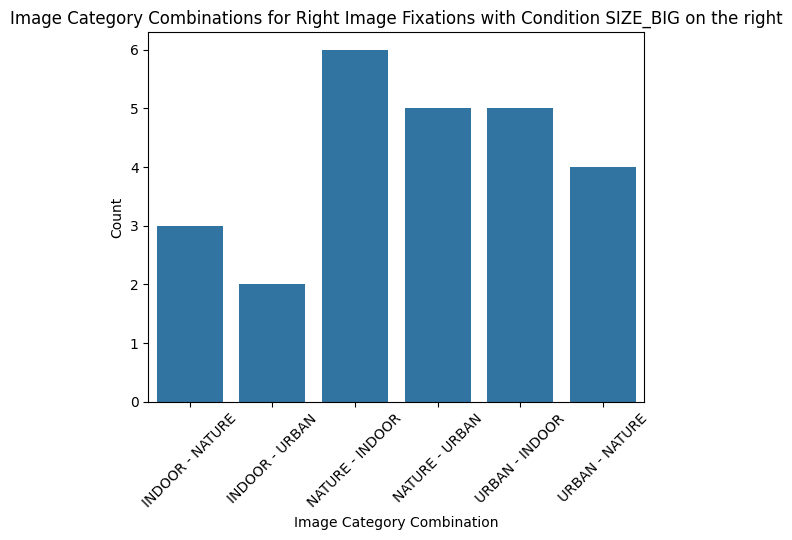

C:\Users\madle\AppData\Local\Temp\ipykernel_21072\2182748536.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  size_big_fixpoints_R_left['ImageCategoryCombination'] = size_big_fixpoints_R_left['left_cat'] + ' - ' + size_big_fixpoints_R_left['right_cat']


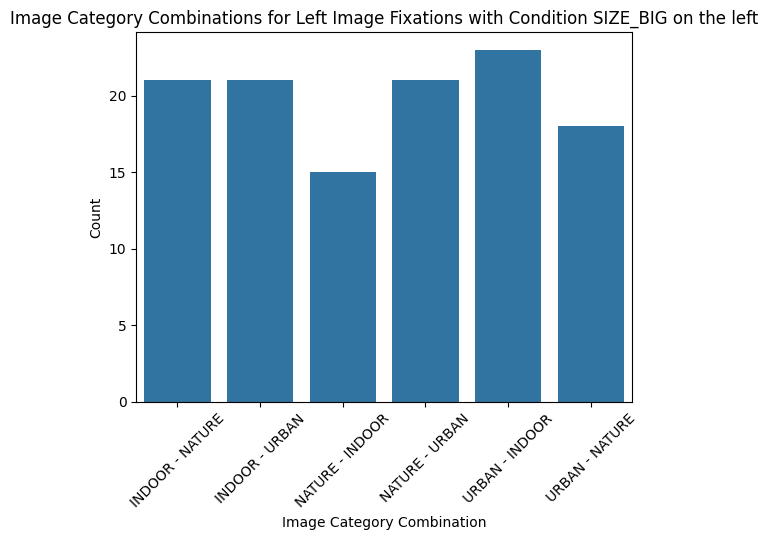

C:\Users\madle\AppData\Local\Temp\ipykernel_21072\2182748536.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  size_big_fixpoints_L = size_big_fixpoints_R[size_big_fixpoints_L['image'] == 'L']


In [ ]:
# find all that have the 'image' R
size_big_fixpoints_R = pd.DataFrame(size_big_fixpoints)
# i want a subset of size_big_fixpoints_df where the image is 'R'
size_big_fixpoints_R = size_big_fixpoints_R[size_big_fixpoints_R['image'] == 'R']
# i want a subset of size_big_fixations_R that have label 'right image'
size_big_fixpoints_R_right = size_big_fixpoints_R[size_big_fixpoints_R['label'] == 'right image']
size_big_fixpoints_R_left = size_big_fixpoints_R[size_big_fixpoints_R['label'] == 'left image']

#for size_big_fixations_R_right i want to investigate the image category combinations of left and right
# i want to plot the combinations of left and right image categories
size_big_fixpoints_R_right['ImageCategoryCombination'] = size_big_fixpoints_R_right['left_cat'] + ' - ' + size_big_fixpoints_R_right['right_cat']
# group by ImageCategoryCombination and count the number of occurrences
size_big_fixpoints_R_right_counts = size_big_fixpoints_R_right.groupby('ImageCategoryCombination').size().reset_index(name='count')
# plot the counts
sns.barplot(data=size_big_fixpoints_R_right_counts, x='ImageCategoryCombination', y='count')
plt.title('Image Category Combinations for Right Image Fixations with Condition SIZE_BIG on the right')  
plt.xlabel('Image Category Combination')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
 
#for size_big_fixations_R_right i want to investigate the image category combinations of left and right
# i want to plot the combinations of left and right image categories
size_big_fixpoints_R_left['ImageCategoryCombination'] = size_big_fixpoints_R_left['left_cat'] + ' - ' + size_big_fixpoints_R_left['right_cat']
# group by ImageCategoryCombination and count the number of occurrences
size_big_fixpoints_R_left_counts = size_big_fixpoints_R_left.groupby('ImageCategoryCombination').size().reset_index(name='count')
# plot the counts
sns.barplot(data=size_big_fixpoints_R_left_counts, x='ImageCategoryCombination', y='count')
plt.title('Image Category Combinations for Left Image Fixations with Condition SIZE_BIG on the left')  
plt.xlabel('Image Category Combination')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# find all that have the 'image' L
size_big_fixpoints_L = pd.DataFrame(size_big_fixpoints)
# i want a subset of size_big_fixpoints_df where the image is 'L'
size_big_fixpoints_L = size_big_fixpoints_R[size_big_fixpoints_L['image'] == 'L']
